In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"takihasan","key":"9afdb7d9dd9d2bcca3148d9ae8f279e3"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d takihasan/commercial-items
!unzip -q commercial-items.zip

kaggle.json
100% 37.7M/37.7M [00:00<00:00, 49.6MB/s]
100% 37.7M/37.7M [00:00<00:00, 51.4MB/s]


In [4]:
import os
import numpy as np
import pandas as pd
from skimage.transform import resize
from tqdm import tqdm
from skimage import io, color
from skimage.transform import resize
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [5]:
TRAIN_DIR= '/content/commercial_items/train/train'
TEST_DIR = '/content/commercial_items/test/test'



In [6]:
!rm -rf /content/commercial_items/train/train/car/
!rm -rf /content/commercial_items/test/test/car/

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data Preparation

In [8]:
all_classes = sorted(os.listdir(TRAIN_DIR))

total_train = 0
total_test = 0
for cls in all_classes:
  train_cls_dir = TRAIN_DIR + "/" + cls + "/" + cls
  num_train = len(os.listdir(train_cls_dir))
  total_train += num_train

  test_cls_dir = TEST_DIR + "/" + cls + "/" + cls
  num_test = len(os.listdir(test_cls_dir))
  total_test += num_test


print(f"Number of training samples in the dataset is {total_train}")
print(f"Number of test samples in the dataset is {total_test}")

Number of training samples in the dataset is 1366
Number of test samples in the dataset is 514


In [9]:
label2id = {cls: i for i, cls in enumerate(all_classes)}
id2label = {i: cls for i, cls in enumerate(all_classes)}
print(label2id)
print(id2label)

{'bottle': 0, 'can': 1, 'cap': 2, 'chair': 3, 'couch': 4, 'cup': 5, 'hat': 6, 'perfume': 7, 'sandal': 8, 'shoe': 9, 'sneaker': 10, 'sunglass': 11, 'toy': 12}
{0: 'bottle', 1: 'can', 2: 'cap', 3: 'chair', 4: 'couch', 5: 'cup', 6: 'hat', 7: 'perfume', 8: 'sandal', 9: 'shoe', 10: 'sneaker', 11: 'sunglass', 12: 'toy'}


In [10]:
from tqdm import tqdm
from skimage import io, color
import os
import numpy as np
from skimage.transform import resize

IMG_HEIGHT = 224
IMG_WIDTH = 224

X_train = np.zeros((total_train, IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
y_train = np.zeros(total_train, dtype=np.uint8)

X_test = np.zeros((total_test, IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
y_test = np.zeros(total_test, dtype=np.uint8)

train_idx = 0
test_idx = 0

for i, cls in tqdm(enumerate(all_classes), total=len(all_classes)):
    train_cls_dir = TRAIN_DIR + "/" + cls + "/" + cls
    train_cls_files = os.listdir(train_cls_dir)

    for image in train_cls_files:
        img_path = train_cls_dir + "/" + image
        img = io.imread(img_path)

        # Check if the image has an alpha channel (4 channels)
        if img.shape[-1] == 4:
            img = color.rgba2rgb(img)

        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range = True)
        X_train[train_idx] = img
        y_train[train_idx] = i
        train_idx += 1

    test_cls_dir = TEST_DIR + "/" + cls + "/" + cls
    test_cls_files = os.listdir(test_cls_dir)
    for image in test_cls_files:
      img_path = test_cls_dir + "/" + image
      img = io.imread(img_path)

      if img.shape[-1] == 4:
        img = color.rgba2rgb(img)

      img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode = 'constant', preserve_range = True)
      X_test[test_idx] = img
      X_test[test_idx] = i
      test_idx += 1





100%|██████████| 13/13 [00:34<00:00,  2.63s/it]


In [11]:
X_train = np.moveaxis(X_train, -1, 1)
X_test =np.moveaxis(X_test, -1, 1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)



X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


batch_size = 32

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [12]:
image, labels = next(iter(train_dataloader))
image.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

# Model Building and Training

In [13]:
!pip install efficientnet-pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=1dd92c5694828a661821dcc06c4ed6e0fed23e671c2590ede7d594dd5b23d223
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt





model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=13)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_dataloader)
    train_accuracy = correct_train / total_train

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_dataloader)
    val_accuracy = correct_val / total_val

    # Save losses and accuracies for visualization
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")



Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 230MB/s]


Loaded pretrained weights for efficientnet-b0
Epoch 1/10, Train Loss: 0.9652, Train Accuracy: 0.7582, Val Loss: 5.1134, Val Accuracy: 0.1058
Epoch 2/10, Train Loss: 0.2030, Train Accuracy: 0.9423, Val Loss: 2.4553, Val Accuracy: 0.3212
Epoch 3/10, Train Loss: 0.1123, Train Accuracy: 0.9698, Val Loss: 0.4678, Val Accuracy: 0.8686
Epoch 4/10, Train Loss: 0.1405, Train Accuracy: 0.9606, Val Loss: 0.4799, Val Accuracy: 0.8942
Epoch 5/10, Train Loss: 0.1212, Train Accuracy: 0.9652, Val Loss: 0.3859, Val Accuracy: 0.9124
Epoch 6/10, Train Loss: 0.1127, Train Accuracy: 0.9679, Val Loss: 0.2219, Val Accuracy: 0.9307
Epoch 7/10, Train Loss: 0.0915, Train Accuracy: 0.9771, Val Loss: 0.5974, Val Accuracy: 0.8942
Epoch 8/10, Train Loss: 0.1311, Train Accuracy: 0.9643, Val Loss: 0.4395, Val Accuracy: 0.9197
Epoch 9/10, Train Loss: 0.1444, Train Accuracy: 0.9643, Val Loss: 0.4736, Val Accuracy: 0.8905
Epoch 10/10, Train Loss: 0.1003, Train Accuracy: 0.9725, Val Loss: 0.5522, Val Accuracy: 0.8796


# Visualization of Training and Validation curves



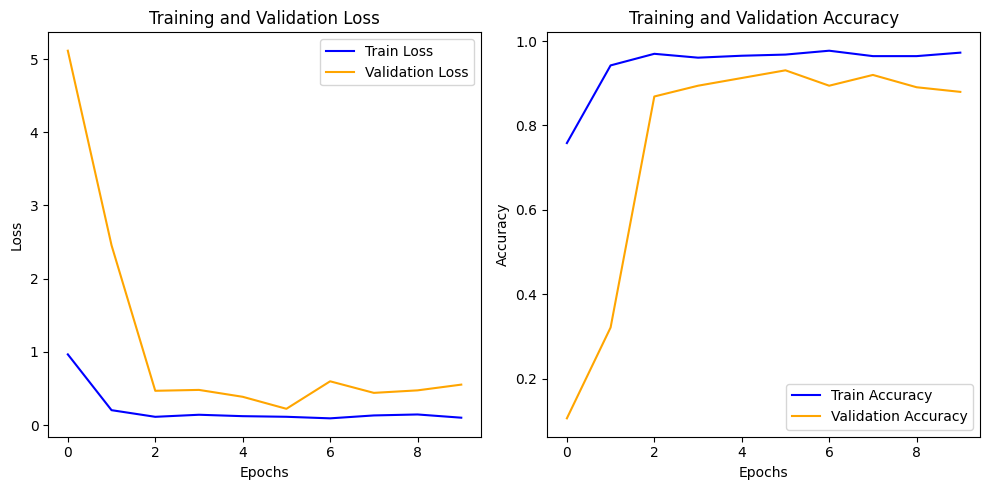

In [15]:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))


axes[0].plot(train_losses, label='Train Loss', color='blue')
axes[0].plot(val_losses, label='Validation Loss', color='orange')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()


axes[1].plot(train_accuracies, label='Train Accuracy', color='blue')
axes[1].plot(val_accuracies, label='Validation Accuracy', color='orange')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()


# Evaluation on Test Set

In [20]:
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


criterion = nn.CrossEntropyLoss()


model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())


test_loss /= len(test_dataloader)
test_accuracy = test_correct / test_total

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')




Test Loss: 0.0000
Test Accuracy: 1.0000


In [17]:
!pip install diffusers

In [2]:
import torch
from diffusers import AutoPipelineForImage2Image
from diffusers.utils import load_image, make_image_grid

pipeline = AutoPipelineForImage2Image.from_pretrained(
    "kandinsky-community/kandinsky-2-2-decoder", torch_dtype=torch.float16, use_safetensors=True
)
pipeline.enable_model_cpu_offload()
# remove following line if xFormers is not installed or you have PyTorch 2.0 or higher installed
pipeline.enable_xformers_memory_efficient_attention()

init_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/cat.png")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

ImportError: `enable_model_cpu_offload` requires `accelerate v0.17.0` or higher.

In [1]:
prompt = "cat wizard, gandalf, lord of the rings, detailed, fantasy, cute, adorable, Pixar, Disney, 8k"
image = pipeline(prompt, image=init_image).images[0]
make_image_grid([init_image, image], rows=1, cols=2)

NameError: name 'pipeline' is not defined